In [145]:
!pip install numpy scipy matplotlib bqplot

import random
import sys
from itertools import combinations

In [146]:
N = 20
x_range = (1, 10)
w_range = (-10, 10)
b_range = (-10, 10)
noise_mean = 0
noise_variance = 10
EPSILON = sys.float_info.epsilon

In [147]:
xs = [random.uniform(*x_range) for _ in range(N)]
W = random.uniform(*w_range)
B = random.uniform(*b_range)
ys = [W*x+B + random.gauss(noise_mean, noise_variance) for x in xs]

In [148]:
from typing import List, Tuple, Callable

Vector = List[float]
NormFunc = Callable[[Vector], float]
Point = Tuple[float, float]

class Line:
    @staticmethod
    def from_slope(slope: float, y0: float):
        return Line(slope, y0)
    
    @staticmethod
    def from_slope_and_point(slope: float, point: Tuple[float, float]):
        y0 = point[1] - point[0] * slope
        return Line.from_slope(slope, y0)

    @staticmethod
    def from_points(p0: Point, p1: Point):
        y_diff = p1[1] - p0[1]
        x_diff = p1[0] - p0[0]
        if abs(x_diff) > EPSILON:
            slope = y_diff / x_diff
        else:
            print("bad things")
            slope = float("inf")
        res = Line(slope, p0[1] - (slope * p0[0]))
        res.x0 = p0[0]
        return res

    def __init__(self, slope: float, y0: float):
        self.slope = slope
        self.y0 = y0

    def __call__(self, x: float) -> float:
        return self.y0 + x * self.slope

In [149]:
def compute_norm_inf(v: Vector) -> float:
    return max([abs(vi) for vi in v])

def compute_norm_2(v: Vector) -> float:
    return sum([vi*vi for vi in v])

def compute_norm_1(v: Vector) -> float:
    return sum([abs(vi) for vi in v])

def compute_norm_0(v: Vector) -> float:
    return sum([1 for vi in v if abs(vi) > EPSILON])


∞-norm
======

We want to minimize
$${\left\lVert w\mathbf{x}+b-\mathbf{y} \right\rVert}_{\infty}$$
Which is equivalent to minimizing
$$\max_i{|w\mathbf{x}_i+b-\mathbf{y}_i|}$$
Which can be expressed as the following linear program:
\begin{equation}
\begin{split}
\text{minimize} \displaystyle \space C \\
\text{subject to} \displaystyle \space &w\mathbf{x}_i+b-\mathbf{y}_i \leq C, i=1 ,..., n\\
                                       -(&w\mathbf{x}_i+b-\mathbf{y}_i) \leq C, i=1 ,..., n\\
                                         &w,b \in (-\infty,\infty), C \geq 0
\end{split}
\end{equation}

In [150]:
from scipy.optimize import linprog

RegressionResult = Tuple[float, Line]

def norm_inf_regression(xs: Vector, ys: Vector) -> RegressionResult:
    pts : List[Point] = zip(xs, ys)

    c = [0, 0, 1]
    A_ub = []
    b_ub = []

    for (xi, yi) in pts:
        A_ub.append([xi, 1, -1])
        b_ub.append(yi)

        A_ub.append([-xi, -1, -1])
        b_ub.append(-yi)

    a_bounds = (None, None)
    b_bounds = (None, None)
    c_bounds = (0, None)

    res = linprog(c, A_ub, b_ub, bounds=(a_bounds, b_bounds, c_bounds), method='interior-point')
    error = res.fun
    slope, y0 = res.x[0], res.x[1]

    return error, Line.from_slope(slope, y0)

error= 1.8395406368809326, w= 4.827854428905683, w'= 4.705449824791904, b= 1.3907690345698995, b'= 2.3646951231021527


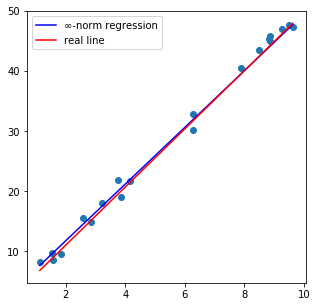

In [151]:
import matplotlib.pyplot as plt

error, line = norm_inf_regression(xs, ys)
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.scatter(xs, ys)
max_x = max(xs)
max_y = max(ys)

min_x = min(xs)
min_y = min(ys)

real_line = Line.from_slope(W, B)

print("error= {}, w= {}, w'= {}, b= {}, b'= {}".format(error, W, line.slope, B, line.y0))

axs.plot([min_x, max_x], [line(min_x), line(max_x)], color='b', label='∞-norm regression')
axs.plot([min_x, max_x], [real_line(min_x), real_line(max_x)], color='r', label='real line')
axs.legend();

2-norm
======

We want to minimize
$${\left\lVert w\mathbf{x}+b-\mathbf{y} \right\rVert}_{2}$$
Which is equivalent to minimizing
$$\sum_1^n{{(w\mathbf{x}_i+b-\mathbf{y}_i)}^2}$$
We can optimize this function by setting the derivative with respect to $w$ and $b$ to 0.
$$\frac{\partial}{\partial w}(\sum_{i=1}^n{{(w\mathbf{x}_i+b-\mathbf{y}_i)}^2})=0 \implies 
\sum_{i=1}^{n}{2x_i(wx_i+b-y_i)}=0
$$
$$\frac{\partial}{\partial b}(\sum_1^n{{(w\mathbf{x}_i+b-\mathbf{y}_i)}^2})=0 \implies
\sum_{i=1}^{n}{2(wx_i+b-y_i)}=0
$$
Solving for $w$ and $b$ we find:
$$
w = \frac{\sum{x_i}\sum{y_i}-n\sum{x_iy_i}}{{(\sum{x_i})}^2-n\sum{x_i^2}}
$$
$$
b = \frac{\sum{x_i^2}\sum{y_i}-\sum{x_iy_i}\sum{x_i}}{n\sum{x_i^2}-{(\sum{x_i})}^2}
$$

In [152]:
def get_error(norm_fn: NormFunc, line: Line, xs: Vector, ys: Vector) -> float:
    y_primes = [line(x) for x in xs]
    error_vector = [y_prime - y for (y_prime, y) in zip(y_primes, ys)]
    return norm_fn(error_vector)


def norm_2_regression(xs: Vector, ys: Vector) -> RegressionResult:
    pts : List[Point] = zip(xs, ys)
    x_sum = sum(xs)
    x_squared_sum = sum([x*x for x in xs])
    y_sum = sum(ys)
    xy_sum = sum([x*y for (x,y) in pts])
    n = len(xs)

    slope = (x_sum*y_sum - n*xy_sum) / (x_sum*x_sum - n*x_squared_sum)
    y0 = (x_squared_sum * y_sum - xy_sum * x_sum) / (n*x_squared_sum - x_sum*x_sum)
    optimal_line = Line.from_slope(slope, y0)
    return get_error(compute_norm_2, optimal_line, xs, ys), optimal_line

error= 20.020040277921467, w= 4.827854428905683, w'= 4.843358706568375, b= 1.3907690345698995, b'= 1.870639285490383


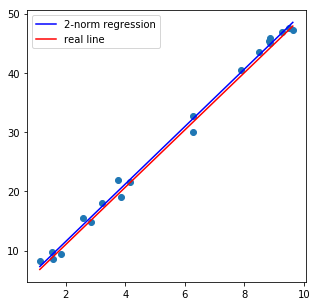

In [153]:
error, line = norm_2_regression(xs, ys)
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.scatter(xs, ys)
min_x = min(xs)
min_y = min(ys)

real_line = Line.from_slope(W, B)

print("error= {}, w= {}, w'= {}, b= {}, b'= {}".format(error, W, line.slope, B, line.y0))

axs.plot([min_x, max_x], [line(min_x), line(max_x)], color='b', label='2-norm regression')
axs.plot([min_x, max_x], [real_line(min_x), real_line(max_x)], color='r', label='real line')
axs.legend();

1-norm
======
We want to minimize
$${\left\lVert w\mathbf{x}+b-\mathbf{y}\right\rVert_1}=\sum_{i=1}^{n}{|wx_i+b-y_i|}$$
Which can be expressed as the following linear program:
\begin{equation}
\begin{split}
\text{minimize} \displaystyle \sum_{i=1}^{n}{C_i} \\
\text{subject to} \displaystyle \space &w\mathbf{x}_i+b-\mathbf{y}_i \leq C_i, i=1 ,..., n\\
                                       -(&w\mathbf{x}_i+b-\mathbf{y}_i) \leq C_i, i=1 ,..., n\\
                                         &w,b \in (-\infty,\infty), C_i \geq 0
\end{split}
\end{equation}

In [154]:
def norm_1_regression_lineprog(xs: Vector, ys: Vector) -> RegressionResult:
    pts : List[Point] = zip(xs, ys)
    number_of_linprog_variables = len(xs) + 2 # one for each point and two for w and b

    c = [1 for _ in range(len(xs))] + [0, 0]
    A_ub = []
    b_ub = []

    for i, (xi, yi) in enumerate(pts):
        prefix = [0 for _ in range(len(xs))]
        prefix[i] = -1
        A_ub.append(prefix + [xi, 1])
        b_ub.append(yi)

        A_ub.append(prefix + [-xi, -1])
        b_ub.append(-yi)

    a_bounds = (None, None)
    b_bounds = (None, None)
    c_bounds = [(0, None) for c in range(len(xs))]

    res = linprog(c, A_ub, b_ub, bounds=c_bounds + [a_bounds, b_bounds], method="interior-point")

    error = res.fun
    slope, y0 = res.x[-2], res.x[-1]

    return error, Line.from_slope(slope, y0)


error= 16.083538326085286, w= 4.827854428905683, w'= 4.8078981456946694, b= 1.3907690345698995, b'= 2.349509272941122


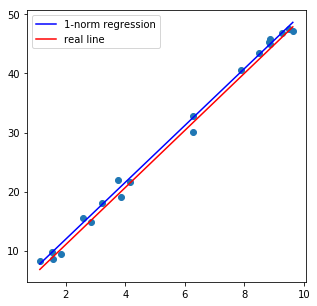

In [155]:
error, line = norm_1_regression_lineprog(xs, ys)
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.scatter(xs, ys)
min_x = min(xs)
min_y = min(ys)

real_line = Line.from_slope(W, B)

print("error= {}, w= {}, w'= {}, b= {}, b'= {}".format(error, W, line.slope, B, line.y0))

axs.plot([min_x, max_x], [line(min_x), line(max_x)], color='b', label='1-norm regression')
axs.plot([min_x, max_x], [real_line(min_x), real_line(max_x)], color='r', label='real line')
axs.legend();

0-norm
======
We simply try all $\binom{n}{2}$ lines that pass through at least two input points and return the one that passes through most points.

In [156]:
from numpy import argmin
def norm_0_regression(xs: Vector, ys: Vector) -> RegressionResult:
    pts : List[Point] = zip(xs, ys)
    lines = [Line.from_points(p0, p1) for (p0, p1) in combinations(pts, 2)]
    min_index : int = argmin([get_error(compute_norm_0, line, xs, ys) for line in lines])
    return get_error(compute_norm_0, lines[min_index], xs, ys), lines[min_index]

error= 18, w= 4.827854428905683, w'= 3.868993375770544, b= 1.3907690345698995, b'= 9.958659351030363


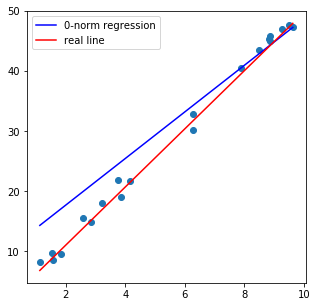

In [157]:
error, line = norm_0_regression(xs, ys)
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.scatter(xs, ys)
min_x = min(xs)
min_y = min(ys)

real_line = Line.from_slope(W, B)

print("error= {}, w= {}, w'= {}, b= {}, b'= {}".format(error, W, line.slope, B, line.y0))

axs.plot([min_x, max_x], [line(min_x), line(max_x)], color='b', label='0-norm regression')
axs.plot([min_x, max_x], [real_line(min_x), real_line(max_x)], color='r', label='real line')
axs.legend();

In [158]:
def get_mse(line, xs, ys):
    return get_error(compute_norm_2, line, xs, ys) / len(xs)

norm: 0-norm, size: 2, mse: 0.0
norm: 1-norm, size: 2, mse: 3.5719472710935305e-14
norm: 2-norm, size: 2, mse: 4.291403324402304e-28
norm: ∞-norm, size: 2, mse: 3.9679004286310506e-21
norm: 0-norm, size: 20, mse: 5.197226846424142
norm: 1-norm, size: 20, mse: 1.0593904801624645
norm: 2-norm, size: 20, mse: 0.9919105241234092
norm: ∞-norm, size: 20, mse: 1.101531017700285
norm: 0-norm, size: 50, mse: 0.9525960624050195
norm: 1-norm, size: 50, mse: 0.8584740515556313
norm: 2-norm, size: 50, mse: 0.8205454804232168
norm: ∞-norm, size: 50, mse: 0.8722983960428927


c:\users\lion\appdata\local\programs\python\python37\lib\site-packages\scipy\optimize\_linprog_ip.py:1262: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  OptimizeWarning)
c:\users\lion\appdata\local\programs\python\python37\lib\site-packages\scipy\optimize\_linprog_ip.py:1274: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you cannot improve the formulation, consider setting 'lstsq' to True. Consider also setting `presolve` to True, if it is not already.
  OptimizeWarning)


norm: 0-norm, size: 100, mse: 62.08153895003501
norm: 1-norm, size: 100, mse: 0.762136132960302
norm: 2-norm, size: 100, mse: 0.7520695144818798
norm: ∞-norm, size: 100, mse: 0.8248533765633512


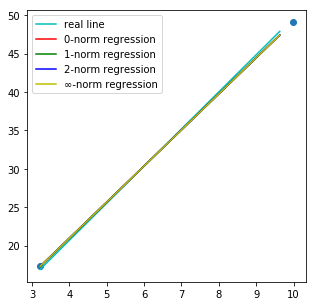

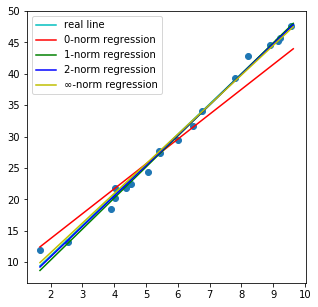

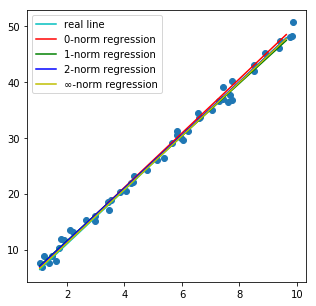

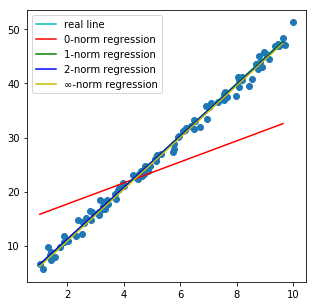

In [159]:
regression_methods = [(norm_0_regression, "0-norm", "r"), (norm_1_regression_lineprog, "1-norm", "g"),
                      (norm_2_regression, "2-norm", "b"), (norm_inf_regression, "∞-norm", "y")]
sizes = [2, 20, 50 ,100]
for size in sizes:
    xs = [random.uniform(*x_range) for _ in range(size)]
    ys = [W*x+B + random.gauss(noise_mean, noise_variance) for x in xs]
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    axs.scatter(xs, ys)
    min_x = min(xs)
    min_y = min(ys)
    real_line = Line.from_slope(W, B)
    axs.plot([min_x, max_x], [real_line(min_x), real_line(max_x)], color='c', label='real line')
    for method, name, color in regression_methods:
        error, line = method(xs, ys)
        mse_error = get_mse(line, xs, ys)
        print("norm: {}, size: {}, mse: {}".format(name, size, mse_error))
        axs.plot([min_x, max_x], [line(min_x), line(max_x)], color=color, label=name + ' regression')
    axs.legend()
        
    

* By increasing $n$, regression lines converge to the optimal line since the expected decrease in probability of all non-optimal lines is more than the expected decrese of the optimal line.
* $w'$ and $b'$ converge to $w$ and $b$ when $n\to\infty$.

Non-(Linear Programming) Methods for $\infty$-norm
==========================================
We could also find the optimal solution by walking the [antipodal points](https://en.wikipedia.org/wiki/Antipodal_point) of the [convex hull](https://en.wikipedia.org/wiki/Convex_hull). First, we compute the convex hull using [Graham scan](https://en.wikipedia.org/wiki/Graham_scan).

In [160]:
def dot2(v1, v2):
    return v1[0] * v2[0] + v1[1] * v2[1]

def find_extemes_in_direction(pts, direction):
    projections = [(point, dot2(point, direction)) for point in pts]

    return (np.argmin([x[1] for x in projections]), np.argmax([x[1] for x in projections]))

def graham_scan_upper_hull(pts):
    '''
        assumes the x coordinate of all points are different
    '''

    assert(len(pts) >= 3)
    sorted_points = sorted(pts, key=lambda p: p[0])
    upper_hull = [sorted_points[0], sorted_points[1]]
    for p in sorted_points[2:]:
        while True:
            current_edge = Line.from_points(upper_hull[-1], p)
            if current_edge(upper_hull[-2][0]) < upper_hull[-2][1]:
                upper_hull.pop()
                if len(upper_hull) == 1:
                    upper_hull.append(p)
                    break
            else:
                upper_hull.append(p)
                break
    return upper_hull

def convex_hull(pts):
    upper_hull = graham_scan_upper_hull(pts)
    lower_hull = [(x, -y) for (x,y) in graham_scan_upper_hull([(x, -y) for (x,y) in pts])]
    lower_hull.reverse()
    return upper_hull + lower_hull[1:-1]

We can test the algorithm by finding the convex hull of random points:

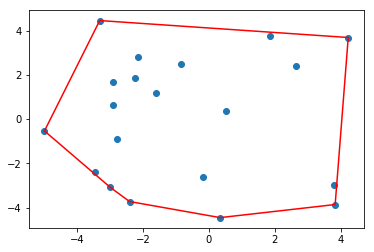

In [161]:
import random
from matplotlib import pyplot as plt

def test_convex_hull():
    random.seed(378465) #for reproducability
    pr = (-5, 5)
    np = 20
    pts = [(random.uniform(*pr), random.uniform(*pr)) for _ in range(np)]
    ch = convex_hull(pts)
    chc = ch + [ch[0]]
    
    plt.scatter([x for x,y in pts], [y for x,y in pts])
    plt.plot([x for x,y in chc], [y for x,y in chc], 'r')

test_convex_hull()

Now we need to iterate on the antipodal points.

In [162]:
import numpy as np
from math import sqrt

def antipodal_points(pts):

    class AntiIterator:

        def __init__(self, pts):
            self.pts = pts

        def __iter__(self):
            self.direction = (1, 0)
            self.current_antipodal_indices = find_extemes_in_direction(self.pts, self.direction)
            self.initial_antipodal_indices = self.current_antipodal_indices
            
            self.initial_min_index = self.current_antipodal_indices[0]
            self.initial_max_index = self.current_antipodal_indices[1]
            
            #print("initial indices: {}".format(self.initial_antipodal_indices))
            self.just_begun = True
            return self

        def __next__(self):
            if self.just_begun:
                self.just_begun = False
                return self.initial_antipodal_indices
            
            self.just_begun = False
            i_min, i_max = self.current_antipodal_indices

            np = len(self.pts)

            p_min = self.pts[i_min]
            p_min_next = self.pts[(i_min + 1) % np]

            p_max = self.pts[i_max]
            p_max_next = self.pts[(i_max + 1) % np]

            min_line = Line.from_points(p_min, p_min_next)
            max_line = Line.from_points(p_max, p_max_next)
            
            
            def n(i):
                return (i+1) % np
            
            current_slope = None
            if self.current_antipodal_indices[0] == self.initial_max_index:
                
                current_slope = Line.from_points(self.pts[i_max], self.pts[n(i_max)])
                self.current_antipodal_indices = (i_min, (i_max + 1) % np)
            elif self.current_antipodal_indices[1] == self.initial_min_index:
                current_slope = Line.from_points(self.pts[i_min], self.pts[n(i_min)])
                self.current_antipodal_indices = ((i_min + 1) % np, i_max)
            elif min_line.slope >= max_line.slope:
                current_slope = Line.from_points(self.pts[i_min], self.pts[n(i_min)])
                self.current_antipodal_indices = ((i_min + 1) % np, i_max)
            else:
                current_slope = Line.from_points(self.pts[i_max], self.pts[n(i_max)])
                self.current_antipodal_indices = (i_min, (i_max + 1) % np)
            
            if (self.current_antipodal_indices[0] == self.initial_antipodal_indices[1]
                and self.current_antipodal_indices[1] == self.initial_antipodal_indices[0]):
                raise StopIteration
            return self.current_antipodal_indices
    return AntiIterator(pts)

def antipodal_points_with_edges(pts):
    antipodal_pts = list(antipodal_points(pts))
    res = []
    index = 0
    def ne(i):
        return (i+1)%len(antipodal_pts)
    
    for i in range(len(antipodal_pts)):
        current_index = i
        next_index = ne(i)
        if next_index == 0:
            antipodal_pts[next_index] = antipodal_pts[next_index][1],antipodal_pts[next_index][0] 
        if antipodal_pts[current_index][0] == antipodal_pts[next_index][0]:
            common = pts[antipodal_pts[current_index][0]]
            tangent_line = Line.from_points(pts[antipodal_pts[current_index][1]],
                                            pts[antipodal_pts[next_index][1]])
            res.append((common, pts[antipodal_pts[current_index][1]], tangent_line.slope))
            res.append((common, pts[antipodal_pts[next_index][1]], tangent_line.slope))
        else:
            common = pts[antipodal_pts[current_index][1]]
            tangent_line = Line.from_points(pts[antipodal_pts[current_index][0]],
                                            pts[antipodal_pts[next_index][0]])
            res.append((pts[antipodal_pts[current_index][0]], common, tangent_line.slope))
            res.append((pts[antipodal_pts[next_index][0]], common, tangent_line.slope))
    return res

We can visualize the antipodal points (requires bqplot (`pip install bqplot`)).

In [163]:
from IPython.display import display
from bqplot import (LinearScale, Axis, Scatter, Lines, Figure)
from ipywidgets import interact

def test_antipodal_points():
    random.seed(378465) #for reproducability
    pr = (-5, 5)
    np = 20
    pts = [(random.uniform(*pr), random.uniform(*pr)) for _ in range(np)]
    ch = convex_hull(pts)
    chc = ch + [ch[0]]
    
    antipodals = antipodal_points_with_edges(ch)
    
    x_scale = LinearScale(min=-7, max=7)
    y_scale = LinearScale(min=-7, max=7)
    
    scales = {'x': x_scale, 'y': y_scale}
    
    x_axis = Axis(scale=x_scale, label='x')
    y_axis = Axis(scale=y_scale, label='y', orientation='vertical')
    axes = [x_axis, y_axis]
    
    points_scatter = Scatter(x=[x for x,_ in pts],
                        y=[y for _,y in pts],
                        scales=scales)
    ch_lines = Lines(x=[x for x,y in chc],y=[y for x,y in chc], scales=scales, colors=['black'])
    
    antipodal_line1 = Lines(x=[0, 0],y=[0, 0], scales=scales, colors=['red'])
    antipodal_line2 = Lines(x=[0, 0],y=[0, 0], scales=scales, colors=['red'])
    ap_points = Scatter(x=[0, 0], y=[0,0], scales=scales, colors=['red'])
    
    figure = Figure(marks = [points_scatter, ch_lines, antipodal_line1, antipodal_line2, ap_points],
                        axes=axes)
    
    
    def update(index):
        p1, p2, slope = antipodals[index]
        
        line1 = Line.from_slope_and_point(slope, p1)
        line2 = Line.from_slope_and_point(slope, p2)
        
        antipodal_line1.x = [-7, 7]
        antipodal_line2.x = [-7, 7]
        
        antipodal_line1.y = [line1(-7), line1(7)]
        antipodal_line2.y = [line2(-7), line2(7)]
        
        ap_points.x = [p1[0], p2[0]]
        ap_points.y = [p1[1], p2[1]]
    
    display(figure)
    interact(update, index=(0, len(antipodals) - 1))

test_antipodal_points()

Figure(axes=[Axis(label='x', scale=LinearScale(max=7.0, min=-7.0)), Axis(label='y', orientation='vertical', sc…

interactive(children=(IntSlider(value=6, description='index', max=13), Output()), _dom_classes=('widget-intera…

Now we can find the antipodal pair with the minimum distance.

In [164]:
def infinite_norm_antipodal(xs, ys):
    pts = list(zip(xs, ys))
    
    ch = convex_hull(pts)
    
    min_distance = float('inf')
    min_line = None
    
    for p1, p2, slope in antipodal_points_with_edges(ch):
        orthogonal_slope = -1/slope
        orthogonal_vector_size =sqrt(1 + 1/(slope*slope))
        orthogonal_vector = (1 / orthogonal_vector_size, -1/(slope * orthogonal_vector_size))
        
        i, j = find_extemes_in_direction(ch, orthogonal_vector)
        pi = ch[i]
        pj = ch[j]
        
        y0_i = pi[1] - pi[0] * slope
        y0_j = pj[1] - pj[0] * slope
        
        dist =abs(y0_i - y0_j) 
        
        if dist < min_distance:
            min_distance = dist
            min_line = Line.from_slope(slope, (y0_i + y0_j)/2)
    return min_distance/2, min_line

We can compare this to the previous method to see if their results match.

In [165]:
from IPython.display import display
from bqplot import (LinearScale, Axis, Scatter, Lines, Figure)

def test_antipodal_inf_regression():
    random.seed(378465) #for reproducability
    pr = (-5, 5)
    np = 20
    
    pts = [(random.uniform(*pr), random.uniform(*pr)) for _ in range(np)]
    xs = [x for x,y in pts]
    ys = [y for x,y in pts]
    
    lp_error, lp_line = norm_inf_regression(xs, ys)
    ap_error, ap_line = infinite_norm_antipodal(xs, ys)
    
    ch = convex_hull(pts)
    chc = ch + [ch[0]]
    
    
    x_scale = LinearScale(min=-7, max=7)
    y_scale = LinearScale(min=-7, max=7)
    
    scales = {'x': x_scale, 'y': y_scale}
    
    x_axis = Axis(scale=x_scale, label='x')
    y_axis = Axis(scale=y_scale, label='y', orientation='vertical')
    axes = [x_axis, y_axis]
    
    points_scatter = Scatter(x=[x for x,_ in pts],
                        y=[y for _,y in pts],
                        scales=scales)
    ch_lines = Lines(x=[x for x,y in chc],y=[y for x,y in chc], scales=scales, colors=['black'])
    
    lp_line_fig = Lines(x=[-7, 7],y=[lp_line(-7), lp_line(7)], scales=scales, colors=['red'], stroke_width=6,
                        labels=["Linear Programming Line"], display_legend=True)
    ap_line_fig = Lines(x=[-7, 7],y=[ap_line(-7), ap_line(7)], scales=scales, colors=['black'], stroke_width=2,
                        labels=["Antipodal Line"], display_legend=True)
    
    figure = Figure(marks = [points_scatter, ch_lines, lp_line_fig, ap_line_fig],
                        axes=axes)

    
    display(figure)

test_antipodal_inf_regression()

Figure(axes=[Axis(label='x', scale=LinearScale(max=7.0, min=-7.0)), Axis(label='y', orientation='vertical', sc…

Non-(Linear Programming) methods for 1-norm
======================================
It is easy to show that there exists an optimal 1-norm line that passes through at least two input points. Therefore we can check all such lines for the one that minimizes the 1-norm.

In [166]:
def norm_1_regression(xs: Vector, ys: Vector):
    pts : List[Point] = list(zip(xs, ys))
    lines = [Line.from_points(p0, p1) for (p0, p1) in combinations(pts, 2)]
    min_index = argmin([get_error(compute_norm_1, line, xs, ys) for line in lines])
    return get_error(compute_norm_1, lines[min_index], xs, ys), lines[min_index]

In [167]:
from IPython.display import display
from bqplot import (LinearScale, Axis, Scatter, Lines, Figure)

def test_norm_1():
    random.seed(378465) #for reproducability
    pr = (-5, 5)
    np = 20
    
    pts = [(random.uniform(*pr), random.uniform(*pr)) for _ in range(np)]
    xs = [x for x,y in pts]
    ys = [y for x,y in pts]
    
    lp_error, lp_line = norm_1_regression_lineprog(xs, ys)
    bf_error, bf_line = norm_1_regression(xs, ys)
    
    ch = convex_hull(pts)
    chc = ch + [ch[0]]
    
    
    x_scale = LinearScale(min=-7, max=7)
    y_scale = LinearScale(min=-7, max=7)
    
    scales = {'x': x_scale, 'y': y_scale}
    
    x_axis = Axis(scale=x_scale, label='x')
    y_axis = Axis(scale=y_scale, label='y', orientation='vertical')
    axes = [x_axis, y_axis]
    
    points_scatter = Scatter(x=[x for x,_ in pts],
                        y=[y for _,y in pts],
                        scales=scales)
    ch_lines = Lines(x=[x for x,y in chc],y=[y for x,y in chc], scales=scales, colors=['black'])
    
    lp_line_fig = Lines(x=[-7, 7],y=[lp_line(-7), lp_line(7)], scales=scales, colors=['red'], stroke_width=6,
                        labels=["Linear Programming Line"], display_legend=True)
    ap_line_fig = Lines(x=[-7, 7],y=[bf_line(-7), bf_line(7)], scales=scales, colors=['black'], stroke_width=2,
                        labels=["Brute-Force Line"], display_legend=True)
    
    figure = Figure(marks = [points_scatter, ch_lines, lp_line_fig, ap_line_fig],
                        axes=axes)

    
    display(figure)

test_norm_1()

Figure(axes=[Axis(label='x', scale=LinearScale(max=7.0, min=-7.0)), Axis(label='y', orientation='vertical', sc…

Gradient Descent Methods
======================
We can also solve these problems using gradient descent, even though it is rather idiotic to do so! The methods presented above are both faster and more accurate than gradient based methods. Nevertheless, for educational purposes we shall implement gradient methods in the following cells.

First, we need a method to compute the gradients. Of course we could easily compute it numerically, but since we are already in the spirit of using suboptimal tools for the job, we are going to do it in a much more complicated and less efficient way: By computing the derivative symbolically!

In [168]:
class Expression:
    
    @staticmethod
    def new_variable(name):
        res = Expression('var')
        res.var_name = name
        return res
    
    @staticmethod
    def if_then_else(cond, if_expr, else_expr):
        if cond is True:
            return if_expr
        elif cond is False:
            return else_expr
            
        res = Expression('if')
        res.cond_expr = cond
        res.if_expr = if_expr
        res.else_expr = else_expr
        return res

    
    def __init__(self, expr_type):
        self.type = expr_type
        
    def __add__(self, other):
        res = Expression('+')
        res.left = self
        res.right = other
        return res
    
    def __radd__(self, other):
        return self.__add__(other)
    
    def __sub__(self, other):
        return self + (-1)*other
    
    def __rsub__(self, other):
        return other + (-1)*self
    
    def __mul__(self, other):
        res = Expression('*')
        res.left = self
        res.right = other
        return res
        
    def __rmul__(self, other):
        return self.__mul__(other)
    
    def __gt__(self, other):
        res = Expression('>')
        res.left = self
        res.right = other
        return res
    
    def __truediv__(self, other):
        res = Expression('/')
        res.left = self
        res.right = other
        return res
    
    def __rtruediv__(self, other):
        res = Expression('/')
        res.left = other
        res.right = self
        return res
    
    
    def derivative(self, var_name):
        return derivative(self, var_name)
    
    def d(self, var):
        if type(var) == Expression:
            return self.derivative(var.var_name)
        return self.derivative(var)
    
    def evaluate(self, **kwargs):
        return evaluate_expression(self, kwargs)
    
    def variable_names(self):
        if self.type == 'var':
            return [self.var_name]
        
        subvars = []
        if self.type in ['+', '*', '/']:
            if type(self.left) == Expression:
                subvars.extend(self.left.variable_names())
            if type(self.right) == Expression:
                subvars.extend(self.right.variable_names())
        if self.type == 'if':
            if type(self.cond_expr) == Expression:
                subvars.extend(self.cond_expr.variable_names())
            if type(self.if_expr) == Expression:
                subvars.extend(self.if_expr.variable_names())
            if type(self.else_expr) == Expression:
                subvars.extend(self.else_expr.variable_names())

        return subvars
                
    
    def __call__(self, *args, **kwargs):
        names = self.variable_names()
        unspecified_names = set(names) - set(kwargs.keys())
        names_sorted_list = sorted(list(unspecified_names))
        for i, x in enumerate(args):
            kwargs[names_sorted_list[i]] = x
        return self.evaluate(**kwargs)
            
    
    def __repr__(self):
        return expression_str(self)
        
def evaluate_expression(expr, var_dic):
    if type(expr) != Expression:
        return expr
    
    if expr.type == 'var':
        return var_dic.get(expr.var_name, expr)
    if expr.type == '>':
        return evaluate_expression(expr.left, var_dic) > evaluate_expression(expr.right, var_dic)
    
    if expr.type == '+':
        return evaluate_expression(expr.left, var_dic) + evaluate_expression(expr.right, var_dic)
    
    if expr.type == '*':
        left = evaluate_expression(expr.left, var_dic) 
        right = evaluate_expression(expr.right, var_dic)
        if left == 0 or right == 0:
            return 0
        return left * right
    
    if expr.type == '/':
        return evaluate_expression(expr.left, var_dic) / evaluate_expression(expr.right, var_dic)
    
    if expr.type == 'if':
        cond = evaluate_expression(expr.cond_expr, var_dic)
        if cond is True:
            return evaluate_expression(expr.if_expr, var_dic)
        elif cond is False:
            return evaluate_expression(expr.else_expr, var_dic)
        else:
            return Expression.if_then_else(cond, evaluate_expression(expr.if_expr, var_dic), 
                                          evaluate_expression(expr.else_expr, var_dic))

            
    
def expression_str(expr):
    if type(expr) != Expression:
        return str(expr)
    
    if expr.type == 'var':
        return expr.var_name
    
    if expr.type in ['+', '*', '/', '>']:
        left_eval = evaluate_expression(expr.left, dict())
        right_eval = evaluate_expression(expr.right, dict())
        
        if expr.type == '+':
            return '(' + expression_str(left_eval) + ') + (' + expression_str(right_eval) + ')'

        if expr.type == '*':
            return '(' + expression_str(left_eval) + ') * (' + expression_str(right_eval) + ')'

        if expr.type == '/':
            return '(' + expression_str(left_eval) + ') / (' + expression_str(right_eval) + ')'

        if expr.type == '>':
            return '(' + expression_str(left_eval) + ') > (' + expression_str(right_eval) + ')'
    
    if expr.type == 'if':
        return 'if ({}) {{{}}} else {{{}}}'.format(expression_str(expr.cond_expr),
                                                  expression_str(expr.if_expr),
                                                  expression_str(expr.else_expr))
    
    
def derivative(expr, var_name):
    if type(expr) != Expression:
        return 0
    
    if expr.type == 'var':
        if expr.var_name == var_name:
            return 1
        else:
            return 0
    
    if expr.type == '+':
        return derivative(expr.left, var_name) + derivative(expr.right, var_name)
    
    if expr.type == '*':
        return derivative(expr.left, var_name) * expr.right + expr.left * derivative(expr.right, var_name)
    
    if expr.type == '/':
        return (derivative(expr.left, var_name) * expr.right -
                derivative(expr.right, var_name) * expr.left) / (expr.right * expr.right)
    
    if expr.type == 'if':
        return Expression.if_then_else(expr.cond_expr,
                        derivative(expr.if_expr, var_name), derivative(expr.else_expr, var_name))

Now we can do cool things like:

In [169]:
x = Expression.new_variable('x')
y = Expression.new_variable('y')

f = 1/x
print("f = {}".format(f))
print("f(2) = {}".format(f(2)))
print("d/dx (f) = {}".format(f.d(x)))
print("d^2/dx^2 (f) = {}".format(f.d(x).d(x)))
print("(d^2/dx^2 (f))(0.5) = {}".format(f.d(x).d(x)(0.5)))

g = 1 / (x*x + y)
print("g = {}".format(g))
print("g(1,2) = {}".format(g(1,2)))
print("g(x=2) = {}".format(g(x=2)))
print("d/dy g = {}".format(g.d(y)))
print("(d/dy g)(1,2) = {}".format(g.d(y)(1,2)))

f = (1) / (x)
f(2) = 0.5
d/dx (f) = (-1) / ((x) * (x))
d^2/dx^2 (f) = ((((((x) * (1)) + ((x) * (1))) * (-1)) * (-1)) + (0)) / (((x) * (x)) * ((x) * (x)))
(d^2/dx^2 (f))(0.5) = 16.0
g = (1) / (((x) * (x)) + (y))
g(1,2) = 0.3333333333333333
g(x=2) = (1) / ((y) + (4))
d/dy g = (-1) / ((((x) * (x)) + (y)) * (((x) * (x)) + (y)))
(d/dy g)(1,2) = -0.1111111111111111


In [170]:
def my_max(x, y):
    return Expression.if_then_else(x > y, x, y)

def max_ls(vs):
    '''
        This function is exponential! Use at your own risk!
    '''
    if len(vs) == 1:
        return vs[0]
    return my_max(vs[0], max_ls(vs[1:]))

def max_ls_fast(vs):
    '''
        find the maximum of a list
    '''
    if len(vs) == 1:
        return vs[0]
    
    pivot = int(len(vs) / 2)
    left = vs[:pivot]
    right = vs[pivot:]
    
    return my_max(max_ls_fast(left), max_ls_fast(right))

def my_abs(x):
    return Expression.if_then_else(x > 0, x, -1 * x)

In [171]:
w = Expression.new_variable('w')
b = Expression.new_variable('b')

norm_2_error = sum([(w*x+b-y)*(w*x+b-y) for x,y in zip(xs, ys)])
norm_1_error = sum([my_abs(w*x+b-y) for x,y in zip(xs, ys)])
norm_inf_error = max_ls_fast([my_abs(w*x+b-y) for x,y in zip(xs, ys)])

In [172]:
def gradient_descent(error, rate=0.00001, max_iterations=1000):
    current_w = 0
    current_b = 0
    
    dw = error.d('w')
    db = error.d('b')
    
    for i in range(max_iterations):
        current_w -= rate * dw(w=current_w, b=current_b)
        current_b -= rate * db(w=current_w, b=current_b)
    return (current_w, current_b)

The numerical version of gradient descent:

In [173]:
def get_norm_inf_error_f(xs, ys):
    def error(w, b):
        return max([abs(w*x+b-y) for x,y in zip(xs, ys)])
    return error
    
def get_norm_2_error_f(xs, ys):
    def error(w, b):
        return sum([(w*x+b-y)**2 for x,y in zip(xs, ys)])
    return error
    
def get_norm_1_error_f(xs, ys):
    def error(w, b):
        return sum([abs(w*x+b-y) for x,y in zip(xs, ys)])
    return error
    
def compute_derivative_fs(error, epsilon=0.0001):
    half_epsilon = epsilon / 2
    def dw(w, b):
        return (error(w+half_epsilon, b) - error(w-half_epsilon, b)) / epsilon
    def db(w, b):
        return (error(w, b+half_epsilon) - error(w, b-half_epsilon)) / epsilon
    return dw, db

def numerical_gradient_decent(error_fn, rate=0.00001, max_iterations=1000):
    dw, db = compute_derivative_fs(error_fn)
    
    w = 0
    b = 0
    
    for i in range(max_iterations):
        w -= rate*dw(w, b)
        b -= rate*db(w, b)
    
    return w,b

In [174]:
print(W, B)
print(numerical_gradient_decent(get_norm_1_error_f(xs, ys), max_iterations=4000, rate=0.0001))
print(gradient_descent(norm_1_error, max_iterations=4000, rate=0.0001))

4.827854428905683 1.3907690345698995
(4.788615704600147, 1.6585927176434865)
(4.789702859988201, 1.660799999999928)
